Read in all data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from utils import stratified_sample, annotate, even_train_split
import glob  # Importing the glob module to find all the files matching a pattern

# Pattern to match the data files
file_pattern = "data_files/user_*/metric_df.csv"

# Initialize a dictionary to store Dataframes for each dataset
all_datasets = {}

# Loop through each file that matches the file pattern
for filepath in glob.glob(file_pattern):
    # print(filepath)
    # print(filepath.split('/'))
    user_name = filepath.split('/')[1]
    print(f"Processing {filepath} dataset...")

    # Read in data file as a pandas dataframe
    data = pd.read_csv(filepath)

    all_datasets[user_name] = data

Processing data_files/user_jason/metric_df.csv dataset...
Processing data_files/user_lauren/metric_df.csv dataset...
Processing data_files/user_lizzie1/metric_df.csv dataset...
Processing data_files/user_lizzie2/metric_df.csv dataset...
Processing data_files/user_sarah1/metric_df.csv dataset...
Processing data_files/user_shreya/metric_df.csv dataset...
Processing data_files/user_sujaan/metric_df.csv dataset...
Processing data_files/user_xiao/metric_df.csv dataset...
Processing data_files/user_yutong/metric_df.csv dataset...


Modeling

/home/jlimkg/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/jlimkg/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/jlimkg/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/jlimkg/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/jlimkg/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/jlimkg/.local/lib/python3.8/site-packages/sklearn

user_jason
user_lauren
user_lizzie1
user_lizzie2
user_sarah1
user_shreya
user_sujaan
user_xiao
user_yutong


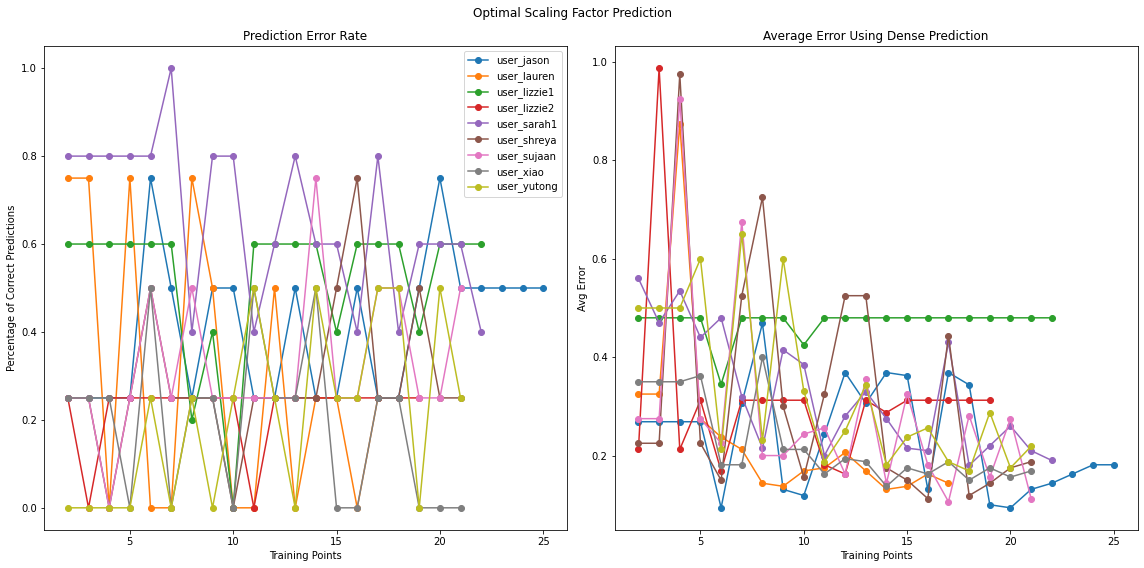

In [5]:
from models import PolyRegression

all_results = {}
for user, data in all_datasets.items():

	#print(user)
	# print(data)
	# Prepare data 
	X = data[['latency', 'scale']]
	data["performance"] = 10*data['throughput'] - data['avg_osd'] - data['avg_target_error']
	Y = data["performance"]

	optimal_match_rate = []
	optimal_scale_error = []
	mse_scores = []
	full_mse_scores = []
	n_train_mse = []
	n_train_full_mse = []

	n = len(data)
	n_train_values = range(2, n-2)
	for n_train in n_train_values:

		# Split into training/test sets
		X_train, X_test, Y_train, Y_test = even_train_split(data, n_train, y_metric="performance")
		# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=n_train/n)

		# Create a meshgrid from the input ranges
		latency_range = np.array(data['latency'].unique())# np.arange(0.0, 0.76, 0.01)
		scale_range = np.arange(0.0, 1.225, 0.025)
		latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
		X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
		X_dense = np.round(X_dense, 3)

		# Apply model, returning predictions over original dataset and dense inputs
		degree = 2
		Y_pred = PolyRegression(X_train, Y_train, X, degree)
		Y_pred_dense = PolyRegression(X_train, Y_train, X_dense, degree)

		## Evaluate metrics
		dense_df = pd.DataFrame({
				'latency': X_dense[:, 0].flatten(),
				'scale': X_dense[:, 1].flatten(),
				'Y_pred_dense': Y_pred_dense.flatten()
			})
		data["Y_pred"] = Y_pred

		full_mse = mean_squared_error(Y, Y_pred)
		if full_mse < 5000:
			n_train_full_mse.append(n_train)
			full_mse_scores.append(full_mse)

		# mse = mean_squared_error(Y_test, Y_test_pred)
		# if mse < 5000:
		# 	n_train_mse.append(n_train)
		# 	mse_scores.append(mse)
		
		optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
		optimal_scale_ref = data.loc[data.groupby('latency')['performance'].idxmax()][['latency', 'scale']]
		optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmax()][['latency', 'scale']]
		# print(optimal_scale_ref)
		# print(optimal_scale_pred)
		# print(optimal_scale_dense)

		# Merge the results on 'latency'
		merged_ref_pred = pd.merge(optimal_scale_ref, optimal_scale_pred, 
							on='latency', suffixes=('_ref', '_pred'))
		
		merged_ref_dense = pd.merge(optimal_scale_ref, optimal_scale_dense, 
							on='latency', suffixes=('_ref', '_dense'))
		

		# Count the number of matches
		matches = (merged_ref_pred['scale_ref'] == merged_ref_pred['scale_pred']).sum()
		scale_error = np.abs(merged_ref_dense['scale_ref'] - merged_ref_dense['scale_dense']).mean()

		optimal_match_rate.append(matches / len(optimal_scale_ref))
		optimal_scale_error.append(scale_error)

	# Store results from this dataset
	all_results[user] = {
		'n_train_mse': list(n_train_mse),
		'n_train_full_mse': list(n_train_full_mse),
		'full_mse_scores': full_mse_scores,
		'mse_scores': mse_scores,
		'n_train_all': range(2, n-2),
		'match_rate': optimal_match_rate,
		'scale_error': optimal_scale_error
	}


# # Plotting the results for all datasets
# fig, axes = plt.subplots(2, 1, figsize=(12, 12))
# fig.suptitle("2nd Order PR Modeling performance Metric")
# for user_name, results in all_results.items():
#       # Extract user name from the filepath
#     axes[0].plot(results['n_train_full_mse'], results['full_mse_scores'], marker='o', label=user_name)
#     axes[1].plot(results['n_train_mse'], results['mse_scores'], marker='o', label=user_name)

# axes[0].set_title('MSE on whole dataset for all users')
# axes[0].set_xlabel('Number of Training Points (n_train)')
# axes[0].set_ylabel('Model Accuracy (MSE Score)')
# axes[0].grid(True)
# axes[0].legend()

# axes[1].set_title('MSE on test set for all users')
# axes[1].set_xlabel('Number of Training Points (n_train)')
# axes[1].set_ylabel('Model Accuracy (MSE Score)')
# axes[1].grid(True)
# axes[1].legend()

# plt.savefig('figures/poly2_evensplit_acc_performance_all_users(2).png')
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Optimal Scaling Factor Prediction")
for user_name, results in all_results.items():
	axes[0].plot(results['n_train_all'], results['match_rate'], marker='o', label=user_name)
	axes[1].plot(results['n_train_all'], results['scale_error'], marker='o', label=user_name)

axes[0].set_title("Prediction Error Rate")
axes[0].set_xlabel("Training Points")
axes[0].set_ylabel("Percentage of Correct Predictions")
axes[0].legend()
axes[1].set_title("Average Error Using Dense Prediction")
axes[1].set_xlabel("Training Points")
axes[1].set_ylabel("Avg Error")

plt.tight_layout()
plt.savefig("figures/optimal_scale_prediction_poly2.png")
plt.show()
